In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Import statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

# Import utils
from utils import grangers_causation_matrix, cointegration_test, adfuller_test, invert_transformation

In [6]:
filepath = 'Binance_ETHUSDT_1h.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
df = df.drop(columns=['unix', 'symbol', 'tradecount', 'Volume USDT', "Volume ETH"]).sort_values(by=['date']).reset_index(drop=True)
print(df.shape) # (1482, 4)

(38146, 4)


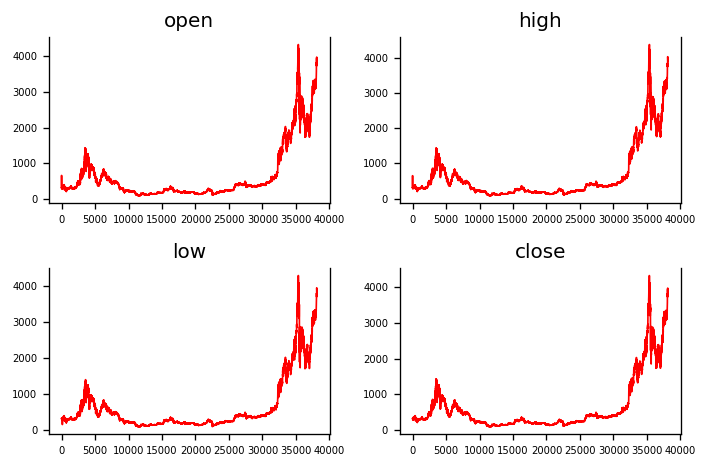

In [7]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120)
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [8]:
test = 'ssr_chi2test'
grangers_causation_matrix(df, variables = df.columns)

,open_x,high_x,low_x,close_x
open_y,1.0,0.0,0.0,0.0
high_y,0.0,1.0,0.0,0.0
low_y,0.0,0.0,1.0,0.0
close_y,0.0,0.0,0.0,1.0


In [9]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
open   ::  18047.27  > 40.1749   =>   True
high   ::  6938.85   > 24.2761   =>   True
low    ::  1372.86   > 12.3212   =>   True
close  ::  5.32      > 4.1296    =>   True


In [10]:
nobs = 240
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (1282, 4)
print(df_test.shape)  # (200, 4)

(37906, 4)
(240, 4)


In [11]:
# Differentiating datasets to make data stationary
df_differenced = df_train.diff().dropna()

In [12]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.3177
 No. Lags Chosen       = 53
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "high" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.5756
 No. Lags Chosen       = 52
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

C:\Users\nkawanto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


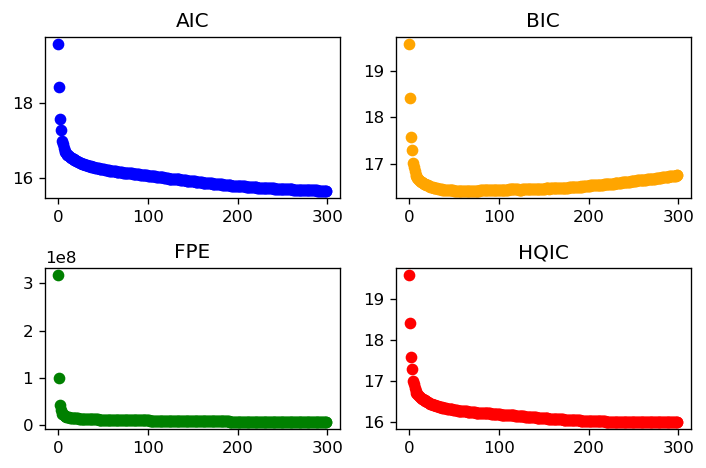

In [13]:
xx = []
yaic = []
ybic = []
yfpe = []
yhqic = []
model = VAR(df_differenced)
for i in range(300):
    result = model.fit(i)
    xx.append(i)
    yaic.append(result.aic)
    ybic.append(result.bic)
    yfpe.append(result.fpe)
    yhqic.append(result.hqic)

fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120)
axes[0,0].plot(xx, yaic, 'o', color='blue')
axes[0,0].set_title("AIC")
axes[0,1].plot(xx, ybic, 'o', color='orange')
axes[0,1].set_title("BIC")
axes[1,0].plot(xx, yfpe, 'o', color='green')
axes[1,0].set_title("FPE")
axes[1,1].plot(xx, yhqic, 'o', color='red')
axes[1,1].set_title("HQIC")
plt.tight_layout()

In [18]:
model_fitted = model.fit(300)
model_fitted.summary()

In [ ]:
# Get lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,open_1d,high_1d,low_1d,close_1d
37906,19.057163,14.134855,39.651774,10.129087
37907,11.045469,5.388887,-0.611316,-4.964019
37908,-2.693529,0.804750,-0.354502,6.344841
37909,-1.336875,-12.509550,-3.805748,-15.426704
37910,-5.304694,7.312414,-9.204155,7.764581
...,...,...,...,...
38141,2.254646,2.462938,-0.958469,-1.859081
38142,-0.481632,-0.023061,0.959786,0.688749
38143,-2.129650,-4.262052,-1.690000,-4.279379
38144,0.085793,0.814295,-0.810462,2.162320


In [ ]:
# Inverting transformation
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['open_forecast', 'high_forecast', 'low_forecast', 'close_forecast']]

open
high
low
close


,open_forecast,high_forecast,low_forecast,close_forecast
37906,3245.937163,3264.134855,3247.791774,3256.449087
37907,3256.982633,3269.523742,3247.180457,3251.485068
37908,3254.289103,3270.328492,3246.825955,3257.829909
37909,3252.952228,3257.818942,3243.020207,3242.403205
37910,3247.647534,3265.131356,3233.816051,3250.167785
...,...,...,...,...
38141,3244.346867,3260.377846,3224.588533,3242.628699
38142,3243.865234,3260.354785,3225.548318,3243.317448
38143,3241.735584,3256.092733,3223.858319,3239.038069
38144,3241.821378,3256.907028,3223.047857,3241.200389


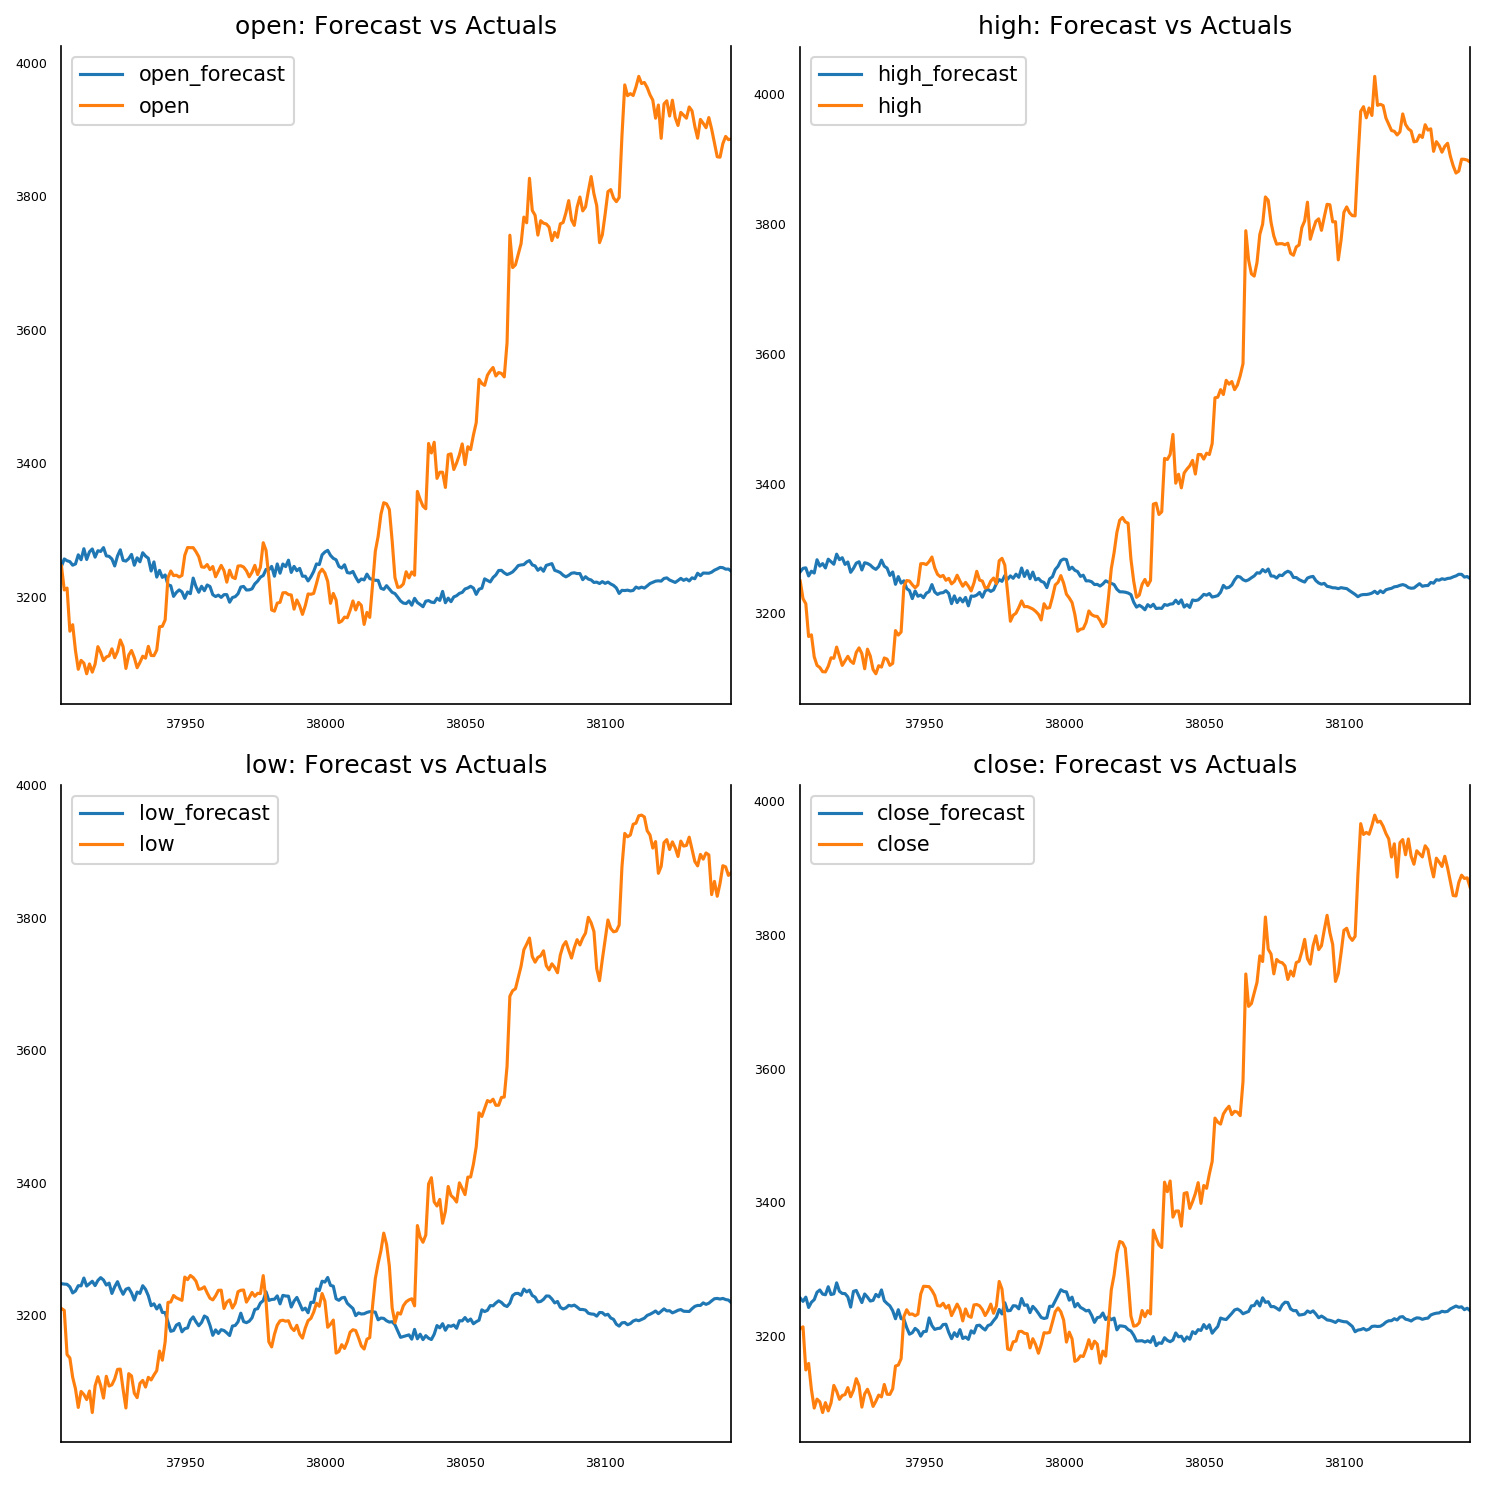

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()